In [1]:
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
using ForneyLab
using NARMAX
import ProgressMeter
using CSV
using DataFrames
using Statistics

In [2]:
using ForneyLab: unsafeMean, unsafeCov, unsafePrecision, Gamma

In [23]:
include("../helpers/polynomial.jl")
include("../helpers/data.jl");

In [28]:
delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}
order_u = delay_u + 1 # u_k, u_{k-1}, u_{k-2}

poly_order = 2
output_ = ϕ(randn(delay_y + delay_u + delay_e + 1), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))


42-element Vector{Float64}:
  1.0
 -1.1818453280112577
  1.3967583793420375
  1.751087619850908
 -2.069514722459149
  3.066307852395118
  0.16864211228787981
 -0.1993088925133807
  0.29530711501281304
  0.028440162036917863
  0.40604438812240157
 -0.4798816630676501
  0.7110193011510745
  ⋮
 -0.020047653250058115
 -0.0019307306797090118
 -0.004648674917765111
  0.015617025103722261
 -0.003997024630906027
  0.00013107242331217062
 -0.5463734084126097
  0.2985239014204124
  0.7653989642720204
  0.5858355745086815
  0.6622820685541791
  0.43861753832840245

In [5]:
function model_specification(ϕ; M1=M1, M2=M2, M3=M3, N=N)

    graph = FactorGraph()

    # Observed variables
    @RV u_kmin1; placeholder(u_kmin1, :u_kmin1, dims=(M1,))
    @RV y_kmin1; placeholder(y_kmin1, :y_kmin1, dims=(M2,))
    @RV e_kmin1; placeholder(e_kmin1, :e_kmin1, dims=(M3,))
    @RV u_k; placeholder(u_k, :u_k)

    # Time-invariant parameters
    @RV τ ~ Gamma(placeholder(:a_τ), placeholder(:b_τ))
    @RV θ ~ GaussianMeanPrecision(placeholder(:m_θ, dims=(N,)), placeholder(:w_θ, dims=(N,N)))

    # Likelihood
    @RV y_k ~ NAutoRegressiveMovingAverageX(θ, u_k, u_kmin1, y_kmin1, e_kmin1, τ, ϕ=ϕ)
    placeholder(y_k, :y_k)

    q = PosteriorFactorization(θ, τ, ids=[:θ :τ])
    algorithm = messagePassingAlgorithm([θ; τ], q, free_energy=true)
    return algorithmSourceCode(algorithm, free_energy=true)
    
end

model_specification (generic function with 1 method)

In [6]:
function experiment_FEM(input_trn, output_trn, input_tst, output_tst, ϕ, priors; M1=1, M2=1, M3=1, N=3, num_iters=5, computeFE=false)

    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    "Inference execution"

    # Extract prior parameters
    θ_k = priors["θ"]
    τ_k = priors["τ"]

    # Initialize marginals
    marginals = Dict(:θ => ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=θ_k[1], w=θ_k[2]),
                     :τ => ProbabilityDistribution(Univariate, Gamma, a=τ_k[1], b=τ_k[2]))

    # Preallocate free energy array
    Fq = zeros(T_trn-maxM, num_iters)

    # Preallocate parameter arrays
    params_θ = (zeros(T_trn-maxM,N), zeros(T_trn-maxM,N,N))
    params_τ = (zeros(T_trn-maxM,1), zeros(T_trn-maxM,1))

    # Preallocate prediction arrays
    predictions = (zeros(T_trn,), zeros(T_trn,))
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)
        
        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1]/τ_k[2])

        # Compute prediction error
        errors[k] = output_trn[k] - predictions[1][k]
        
        # Set data 
        data = Dict(:y_k => output_trn[k],
                    :u_k => input_trn[k],
                    :u_kmin1 => u_kmin1,
                    :y_kmin1 => y_kmin1,
                    :e_kmin1 => e_kmin1,
                    :m_θ => θ_k[1],
                    :w_θ => θ_k[2],
                    :a_τ => τ_k[1],
                    :b_τ => τ_k[2])
        
        # Iterate updates
        for n = 1:num_iters
            
            # Compute free energy
            if computeFE
                Fq[ii,n] = freeEnergy(data,marginals)
            end
            
            # Update parameters
            stepθ!(data, marginals)
            stepτ!(data, marginals)
            
        end 
        
        # Update params
        θ_k = (unsafeMean(marginals[:θ]), unsafePrecision(marginals[:θ]))
        τ_k = (marginals[:τ].params[:a], marginals[:τ].params[:b])
        
        # Store params
        params_θ[1][ii,:] = θ_k[1]
        params_θ[2][ii,:,:] = θ_k[2]
        params_τ[1][ii] = τ_k[1]
        params_τ[2][ii] = τ_k[2]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = (zeros(T_tst,), zeros(T_tst,))
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[1][k] = θ_k[1]'*ϕx
        # predictions[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])

        # Update error
        errors[k] = output_tst[k] - predictions[1][k]
        
    end

    "Simulation"

    # Prepare array
    simulations = (zeros(T_tst,), zeros(T_tst,))

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[1][k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[1][k] = θ_k[1]'*ϕx
        
        # simulations[2][k] = ϕx'*inv(θ_k[2])*ϕx + inv(τ_k[1] / τ_k[2])
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[1][maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[1][maxM+1:end] - output_tst[maxM+1:end]).^2))

    if computeFE
        return RMS_sim, RMS_prd, Fq
    else
        return RMS_sim, RMS_prd, simulations, predictions, θ_k[1]
    end
end

experiment_FEM (generic function with 1 method)

In [7]:
function experiment_RLS(input_trn, output_trn, input_tst, output_tst, ϕ; M1=1, M2=1, M3=1, N=1, λ=1.00)
    
    # Maximum delay
    maxM = maximum([M1,M2,M3])

    # Zero-padding of signals
    input_trn = [zeros(maxM,); input_trn]
    input_tst = [zeros(maxM,); input_tst]
    output_trn = [zeros(maxM,); output_trn]
    output_tst = [zeros(maxM,); output_tst]

    # Signal splits
    T_trn = length(input_trn)
    T_tst = length(input_tst)

    # Parameters
    P = λ.*Matrix{Float64}(I,N,N)
    w_k = zeros(N,)

    # Preallocate prediction array
    predictions = zeros(T_trn,)
    errors = zeros(T_trn,)

    for (ii,k) in enumerate(maxM+1:T_trn)

        # Update history vectors
        u_kmin1 = input_trn[k-1:-1:k-M1]
        y_kmin1 = output_trn[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
        
        # Update data vector
        ϕx = ϕ([input_trn[k]; u_kmin1; y_kmin1; e_kmin1])
        
        # Update weights
        α = output_trn[k] - w_k'*ϕx 
        g = P*ϕx*inv(λ + ϕx'*P*ϕx)
        P = inv(λ)*P - g*ϕx'*inv(λ)*P
        w_k = w_k + α*g
        
        # Prediction
        predictions[k] = w_k'*ϕx
        errors[k] = output_trn[k] - predictions[k]
        
    end

    "1-step ahead prediction"
    
    # Prepare array
    predictions = zeros(T_tst,)
    errors = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = output_tst[k-1:-1:k-M2]
        e_kmin1 = errors[k-1:-1:k-M3]
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        predictions[k] = w_k'*ϕx

        # Update error
        errors[k] = output_tst[k] - predictions[k]
        
    end

    "Simulation"

    # Prepare array
    simulations = zeros(T_tst,)

    for k in maxM+1:T_tst
        
        # Update history vectors
        u_kmin1 = input_tst[k-1:-1:k-M1]
        y_kmin1 = simulations[k-1:-1:k-M2]
        e_kmin1 = zeros(M3,)
            
        # Posterior predictive
        ϕx = ϕ([input_tst[k]; u_kmin1; y_kmin1; e_kmin1])
        simulations[k] = w_k'*ϕx
        
    end

    "Evaluation"

    # Compute root mean square error
    RMS_prd = sqrt(mean((predictions[maxM+1:end] - output_tst[maxM+1:end]).^2))
    RMS_sim = sqrt(mean((simulations[maxM+1:end] - output_tst[maxM+1:end]).^2))

    return RMS_sim, RMS_prd, simulations, predictions, w_k
end

experiment_RLS (generic function with 1 method)

### Real dataset

In [8]:

df = DataFrame(CSV.File("../datasets/cascadedtanks/dataBenchmark.csv"))[1:1000, :];
u_train, u_val, y_train, y_val = df[:,1], df[:,2], df[:,3], df[:,4]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = input_trn
# input_val = input_val

### Synthetic dataset

In [9]:
# find order
M1, M2, M3 = 3,3, 3
poly_order = 2
options = Dict("na"=>M1, "nb"=>M2, "ne"=>M3, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false)

PΦ = gen_combs(options)
ϕ_fl(x::Array{Float64,1}) = [prod(x.^PΦ[:,k]) for k = 1:size(PΦ,2)]
N = size(PΦ,2)

42

In [24]:
seed = 42
syn_input, syn_noise, syn_output, η_true = generate_data(seed, ϕ, options, scale_coef=0.2);

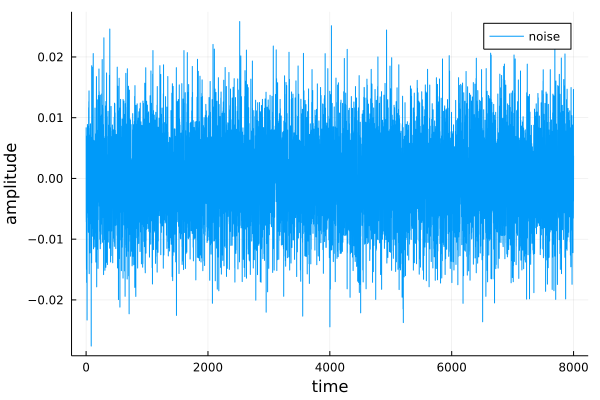

In [25]:
# Visualize noise
plot(syn_noise, xlabel="time", ylabel="amplitude", label="noise")

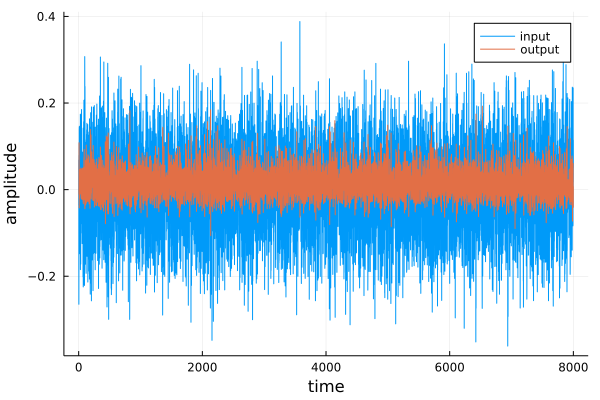

In [26]:
# Plot both input and outputs
plot(syn_input, label="input")
plot!(syn_output, xlabel="time", ylabel="amplitude", label="output")

In [29]:
train_size = 5000+order_u
test_size = 1000+order_u

u_train = syn_input[1:train_size]
u_val = syn_input[train_size + 1:train_size + test_size]
y_train = syn_output[1:train_size]
y_val = syn_output[train_size + 1:train_size + test_size]

# normalization
m_y, s_y = mean(y_train), std(y_train)
m_u, s_u = mean(u_train), std(u_train)
output_trn = (y_train .- m_y) ./ s_y
output_val = (y_val .- m_y) ./ s_y
input_trn = (u_train .- m_u) ./ s_u
input_val = (u_val .- m_u) ./ s_u;

# output_trn = y_train
# output_val = y_val
# input_trn = u_train
# input_val = u_val

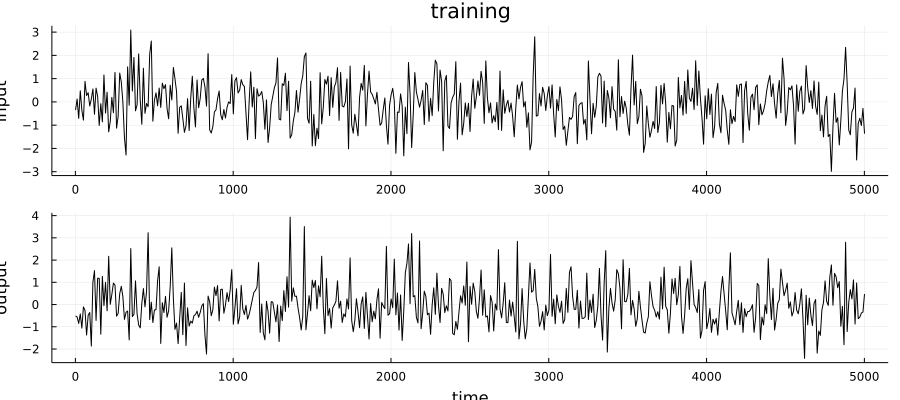

In [30]:
# Plot every n-th time-point to avoid figure size exploding
n = 10
ix = 1:n:length(output_trn)

# Plot training signals
p1a = plot(ix, input_trn[ix], color="black", label="", xlabel="", ylabel="input", title="training")    
p1b = plot(ix, output_trn[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

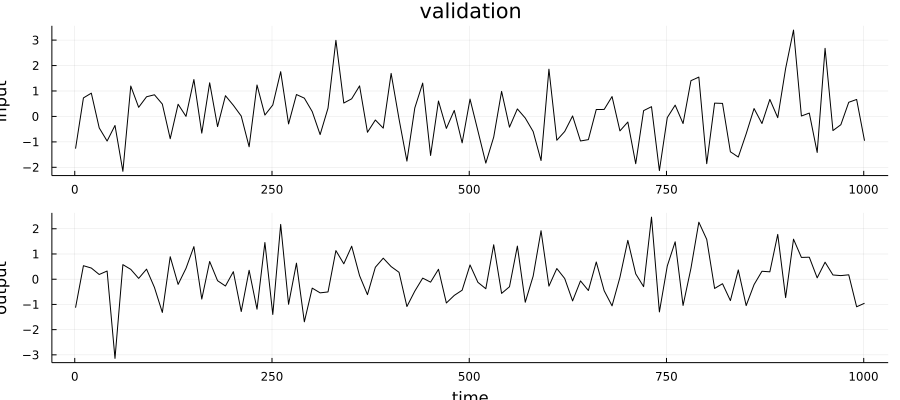

In [31]:
n = 10
ix = 1:n:length(output_val)

# Plot validation signals
p1a = plot(ix, input_val[ix], color="black", label="", xlabel="", ylabel="input", title="validation")    
p1b = plot(ix, output_val[ix], color="black", label="", xlabel="time", ylabel="output", size=(900,400))    
p1 = plot(p1a, p1b, layout=(2,1))

In [32]:
# find order
seed = 42

delay_y, delay_u, delay_e = 3, 3, 3
order_h = delay_e + 1 # e_k, e_{k-1}, e_{k-2}

poly_order = 2

output__ = ϕ(randn(sum([delay_u, delay_y, order_h])), Dict("na"=>delay_y, "nb"=>delay_u, "ne"=>delay_e, "nd"=>poly_order, "dc"=>true, "crossTerms"=>true, "noiseCrossTerms"=>false))
full_order = length(output__)

42

### prepare training/test sets 

In [33]:
# Generate training data
observations_prev, observations = ssm(output_trn, delay_y)
controls = ssm(input_trn, order_u)[1]
X_train, Y_train, U_train = observations_prev[1:train_size-order_u], observations[1:train_size-order_u], controls[1:train_size-order_u];

# Generate validation data
observations_prev, observations = ssm(output_val, delay_y)
controls = ssm(input_val, order_u)[1]
X_test, Y_test, U_test = observations_prev[1:test_size-order_u], observations[1:test_size-order_u], controls[1:test_size-order_u];

In [34]:
# Specify model and compile update functions
source_code = model_specification(ϕ_fl, M1=M1, M2=M2, M3=M3, N=N)
eval(Meta.parse(source_code))

freeEnergy (generic function with 1 method)

In [44]:
# Initialize priors
priors = Dict("θ" => (zeros(N,), Matrix{Float64}(I,N,N)), 
              "τ" => (1.0, 1.0))
prior_mτ = priors["τ"][1] ./ priors["τ"][2]  

1.0

In [51]:
rms_sim, rms_pred, sim, pred, coefs = experiment_FEM(input_trn, output_trn, input_val, output_val, ϕ_fl, priors, M1=M1, M2=M2, M3=M3, N=N, num_iters=20, computeFE=false)

(0.29300071561698726, 0.22826621377619452, ([0.0, 0.0, 0.0, -0.002414919324196783, -0.01723741821440475, 0.3272584710046378, 1.9461471462236484, 0.691494325074405, -1.1201837186801866, -1.6519707909773085  …  0.005920257858050355, 0.8021761257380431, -0.30424337878292484, 1.2035177161669444, 1.1487788391434763, -0.47560815942699597, -1.2253935756612182, -0.9921326786614632, 0.8777445131691144, 0.9988530960171901], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ([0.0, 0.0, 0.0, -0.002414919324196783, 0.33010917793571043, 0.4574251441460491, 2.7256162160221624, 0.8303277154986484, -1.0679561333833614, -1.7058912201615488  …  -0.17814379501083435, 0.5102214011627155, -0.39073583033138204, 1.1525785607557766, 1.3684695146183854, -0.36126830114051434, -0.9722966876599605, -0.6711592754183624, 1.0120437429156515, 0.8804007926602726], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

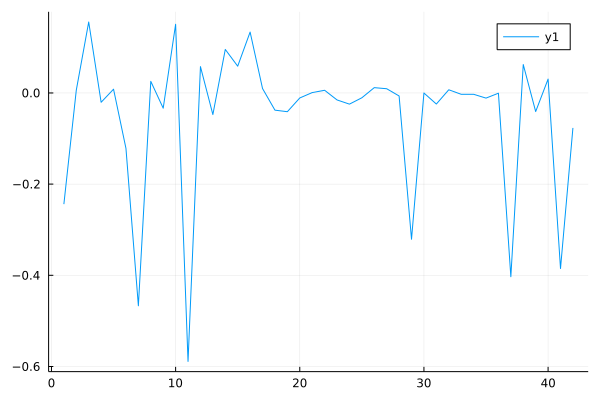

In [52]:
plot(coefs)

In [53]:
println(coefs)

[-0.24390899402025573, 0.006098124220249518, 0.15558729588617445, -0.020515532292784164, 0.008239427545094928, -0.12163116299279994, -0.46682440383387686, 0.0254339464385204, -0.03343171223571427, 0.1505506850919556, -0.5888611443906859, 0.05771745084681749, -0.04744608303577129, 0.09539301783919642, 0.05867274378383659, 0.1335178633314434, 0.009698373199998393, -0.03776941872672576, -0.04114822141247473, -0.011033897268755165, 0.0007657884276606897, 0.005832322728408348, -0.015339137720813892, -0.024554563387865908, -0.010628356023297644, 0.01160326322439556, 0.00922137280201857, -0.00665085521886546, -0.32092498043624573, -0.0001423632105688529, -0.024344527492862165, 0.006930141102854202, -0.0029688827966313173, -0.002948422331181387, -0.011332759214569343, -0.0005998586645148702, -0.4031081710838545, 0.06228908673956017, -0.04085410671018379, 0.03039308107020118, -0.3851652733351417, -0.0767388425511546]


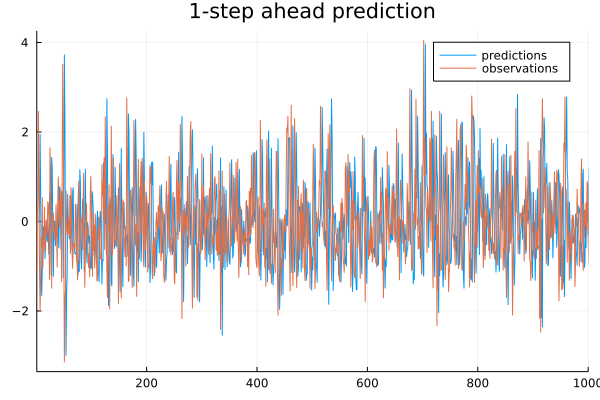

In [54]:
plot(sim[1], label="predictions")
plot!(output_val, xlims=(1, 1000), title="1-step ahead prediction", label="observations")

In [55]:
rms_sim, rms_pred, sim, pred, coefs = experiment_RLS(input_trn, output_trn, input_val, output_val, ϕ_fl, M1=M1, M2=M2, M3=M3, N=N, λ=1.0)

(0.29288293490722445, 0.22743100731304236, [0.0, 0.0, 0.0, -0.0031936399957808725, -0.015303993374551239, 0.317266416562049, 1.9488121942639807, 0.7016169103836284, -1.108349204174642, -1.653068803001023  …  0.012922435946473444, 0.7982412074294679, -0.30118094105715115, 1.1881653791674878, 1.1634861131118834, -0.469031258303608, -1.22218382486989, -1.0015708806696235, 0.8787081306399297, 1.005853601067419], [0.0, 0.0, 0.0, -0.0031936399957808725, 0.2813747523774959, 0.33940576232653324, 2.7386866568027037, 0.82930151729359, -1.1120811684759482, -1.7113325527826506  …  -0.19695398334318068, 0.5007096494703418, -0.3985077113256445, 1.120668399777356, 1.3695771443704605, -0.37204565900330566, -1.0052139742135675, -0.6729564528245933, 1.0143322723360162, 0.8592769344186834], [-0.2413913358323754, 0.006510413045527041, 0.15385507427724313, -0.01959753306934911, 0.010888823736662221, -0.12138018540761039, -0.4672676686836971, 0.027312884165934304, -0.03493729643427372, 0.1486506065196006  …

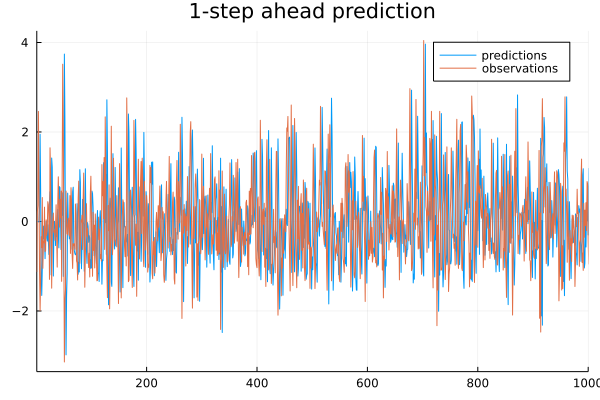

In [41]:
plot(sim, label="predictions")
plot!(output_val, xlims=(1, 1000), title="1-step ahead prediction", label="observations")